News Dataset:
                                                 Link  \
0  https://edition.cnn.com/2023/09/29/business/st...   
1  https://www.channelnewsasia.com/singapore/su-w...   
2  https://edition.cnn.com/2023/05/22/tech/meta-f...   
3  https://www.channelnewsasia.com/singapore/bill...   
4  https://edition.cnn.com/2024/03/05/politics/li...   

                                                Text  content_length language  \
0  Starbucks violated federal labor law when it i...             680       en   
1  The first suspect to plead guilty in Singapore...             740       en   
2  Meta has been fined a record-breaking €1.2 bil...             891       en   
3  SINGAPORE: A 45-year-old man linked to Singapo...             602       en   
4  The Department of Education imposed a record $...             850       en   

   valid_format  accessible  \
0          True         NaN   
1          True         NaN   
2          True         NaN   
3          True         NaN   
4     

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


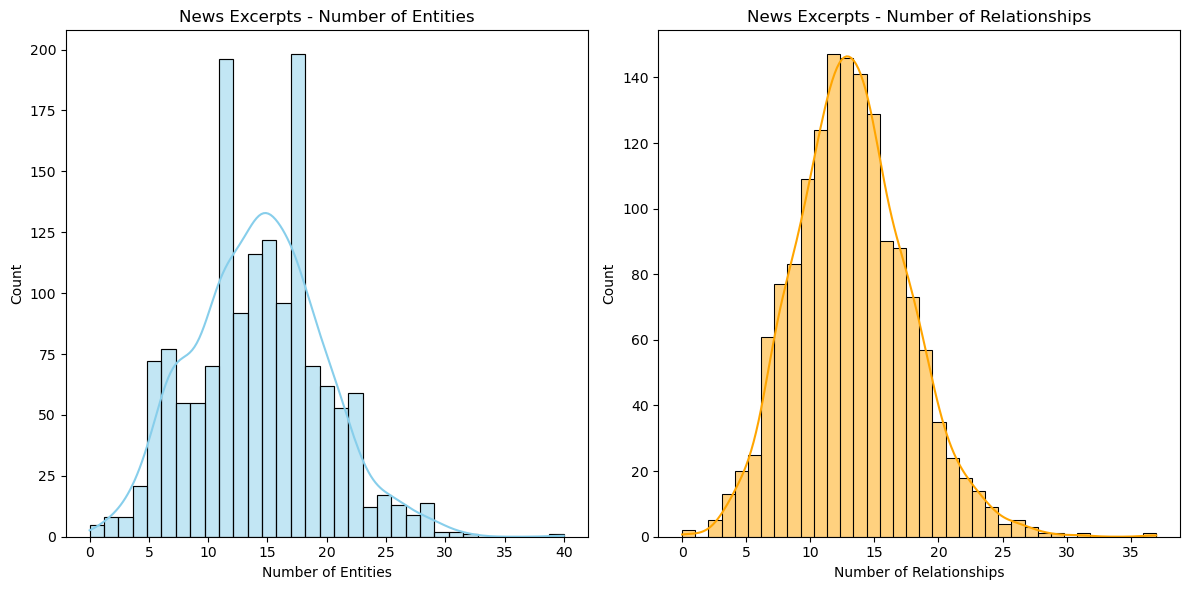

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


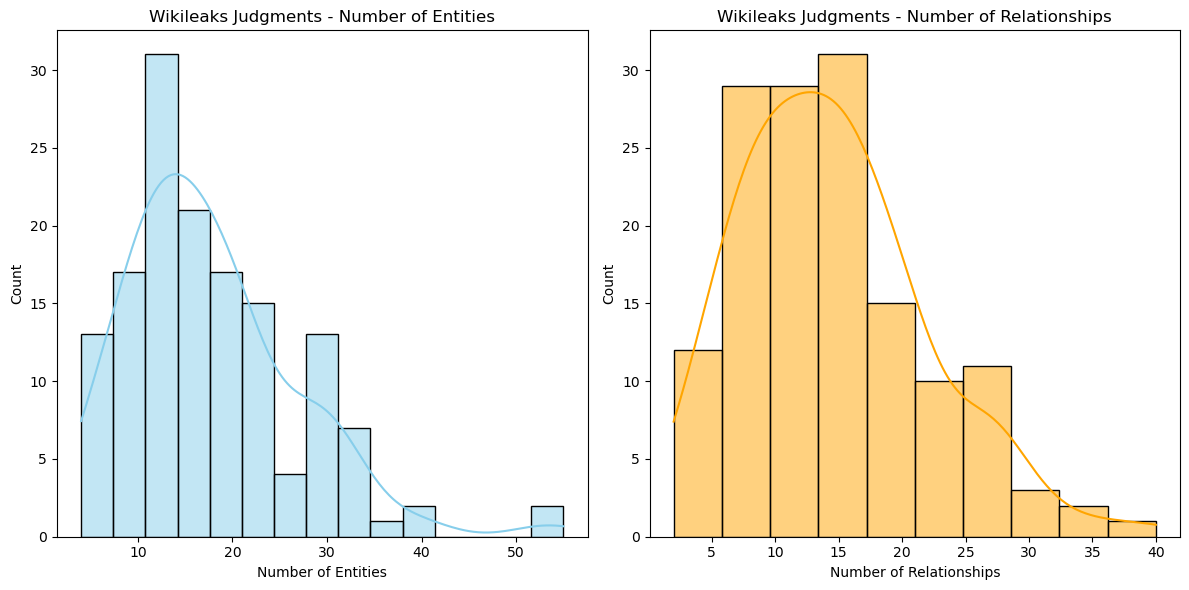

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Load the datasets
news_df = pd.read_excel("entity_SA_newsexcerpt.xlsx")
wikileaks_df = pd.read_excel("entity_SA_wikileaks.xlsx")

# Data overview
print("News Dataset:\n", news_df.head())
print("Wikileaks Dataset:\n", wikileaks_df.head())

# Summarize the number of entities and relationships
def summarize_data(df, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    sns.histplot(df['num_entities'], kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"{title} - Number of Entities")
    axes[0].set_xlabel("Number of Entities")
    
    sns.histplot(df['num_relationships'], kde=True, ax=axes[1], color="orange")
    axes[1].set_title(f"{title} - Number of Relationships")
    axes[1].set_xlabel("Number of Relationships")
    
    plt.tight_layout()
    plt.show()

summarize_data(news_df, "News Excerpts")
summarize_data(wikileaks_df, "Wikileaks Judgments")




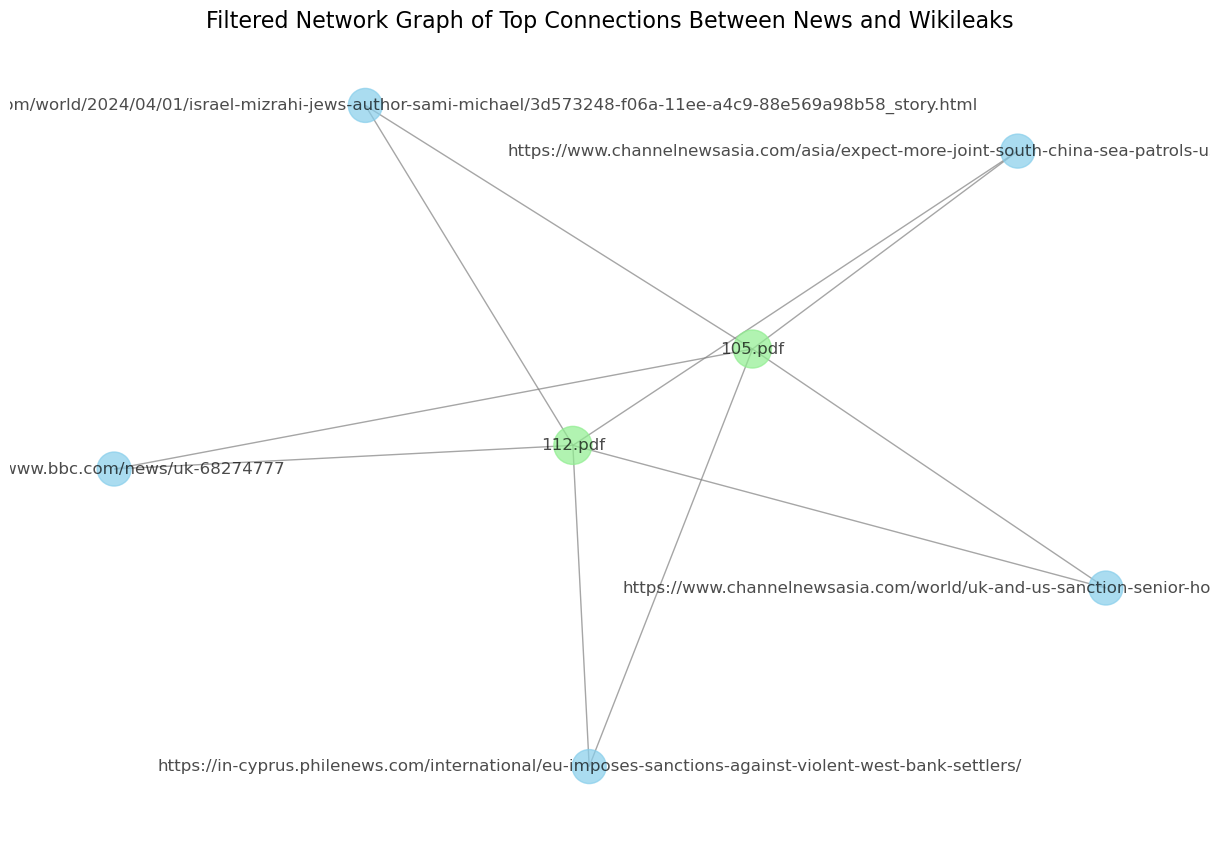

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Load the Excel files
news_df = pd.read_excel("entity_SA_newsexcerpt.xlsx")
wikileaks_df = pd.read_excel("entity_SA_wikileaks.xlsx")

# Extract entities
news_entities = news_df['entities'].str.split(',').explode()
wikileaks_entities = wikileaks_df['entities'].str.split(',').explode()

# Count most common entities in both datasets
news_entity_counts = Counter(news_entities.dropna())
wikileaks_entity_counts = Counter(wikileaks_entities.dropna())

# Select the top 10 entities from each dataset
common_news_entities = set([entity for entity, _ in news_entity_counts.most_common(10)])
common_wikileaks_entities = set([entity for entity, _ in wikileaks_entity_counts.most_common(10)])

# Filter rows to only include rows with top entities
news_df_filtered = news_df[news_df['entities'].apply(lambda x: any(e in x for e in common_news_entities) if pd.notnull(x) else False)]
wikileaks_df_filtered = wikileaks_df[wikileaks_df['entities'].apply(lambda x: any(e in x for e in common_wikileaks_entities) if pd.notnull(x) else False)]

# Create a graph
G = nx.Graph()

# Add nodes for news articles and Wikileaks judgments
for _, row in news_df_filtered.iterrows():
    G.add_node(row['Link'], type='news')

for _, row in wikileaks_df_filtered.iterrows():
    G.add_node(row['PDF Path'], type='wikileaks')

# Add edges for shared entities with weights
for _, news_row in news_df_filtered.iterrows():
    for _, wiki_row in wikileaks_df_filtered.iterrows():
        news_entities = set(news_row['entities'].split(',')) if pd.notnull(news_row['entities']) else set()
        wiki_entities = set(wiki_row['entities'].split(',')) if pd.notnull(wiki_row['entities']) else set()
        common_entities = news_entities & wiki_entities
        if common_entities:
            G.add_edge(news_row['Link'], wiki_row['PDF Path'], weight=len(common_entities))

# Identify the top 5 weighted edges to create a cleaner graph
top_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:5]
top_edge_nodes = set([u for u, v, _ in top_edges] + [v for u, v, _ in top_edges])

# Create a subgraph with the top edges
subgraph = G.subgraph(top_edge_nodes)

# Draw the subgraph
plt.figure(figsize=(12, 8))

# Define node colors based on type
node_colors = ["skyblue" if subgraph.nodes[node]['type'] == 'news' else "lightgreen" for node in subgraph]

# Define node sizes based on degree
node_sizes = [500 + 50 * subgraph.degree[node] for node in subgraph]

# Draw network
pos = nx.spring_layout(subgraph, seed=42)  # Neat layout
nx.draw(
    subgraph, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, edge_color="gray", alpha=0.7
)

plt.title("Filtered Network Graph of Top Connections Between News and Wikileaks", fontsize=16)
plt.show()


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast

# Load the data
newsexcerpt_path = "./data/entity_SA_newsexcerpt.xlsx"
wikileaks_path = "./data/entity_SA_wikileaks.xlsx"

df_newsexcerpt = pd.read_excel(newsexcerpt_path)
df_wikileaks = pd.read_excel(wikileaks_path)

# Utility function to parse list-like strings to Python lists
def parse_list_column(column):
    return column.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Parse columns for entities, relationships, and sentiments
df_newsexcerpt['entities'] = parse_list_column(df_newsexcerpt['entities'])
df_newsexcerpt['relationships'] = parse_list_column(df_newsexcerpt['relationships'])
df_newsexcerpt['entity_sentiments'] = parse_list_column(df_newsexcerpt['entity_sentiments'])

df_wikileaks['entities'] = parse_list_column(df_wikileaks['entities'])
df_wikileaks['relationships'] = parse_list_column(df_wikileaks['relationships'])
df_wikileaks['entity_sentiments'] = parse_list_column(df_wikileaks['entity_sentiments'])

# Visualization functions
def visualize_entities(df, title):
    entity_counts = Counter([entity[0] for entities in df['entities'] for entity in entities])
    top_entities = dict(entity_counts.most_common(10))

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(top_entities.values()), y=list(top_entities.keys()), palette="viridis")
    plt.title(f"Top 10 Entities - {title}")
    plt.xlabel("Frequency")
    plt.ylabel("Entity")
    plt.show()

def visualize_relationships(df, title):
    relationship_counts = Counter([rel[1] for relationships in df['relationships'] for rel in relationships])
    top_relationships = dict(relationship_counts.most_common(10))

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(top_relationships.values()), y=list(top_relationships.keys()), palette="coolwarm")
    plt.title(f"Top 10 Relationships - {title}")
    plt.xlabel("Frequency")
    plt.ylabel("Relationship")
    plt.show()

def visualize_sentiments(df, title):
    sentiment_counts = Counter([sent['sentiment'] for sentiments in df['entity_sentiments'] for sent in sentiments])

    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(sentiment_counts.keys()), y=list(sentiment_counts.values()), palette="Set2")
    plt.title(f"Sentiment Distribution - {title}")
    plt.xlabel("Sentiment")
    plt.ylabel("Frequency")
    plt.show()

def visualize_content_length(df, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['content_length'], bins=20, kde=True, color='purple')
    plt.title(f"Content Length Distribution - {title}")
    plt.xlabel("Content Length")
    plt.ylabel("Frequency")
    plt.show()



Visualizations for entity_SA_newsexcerpt


/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


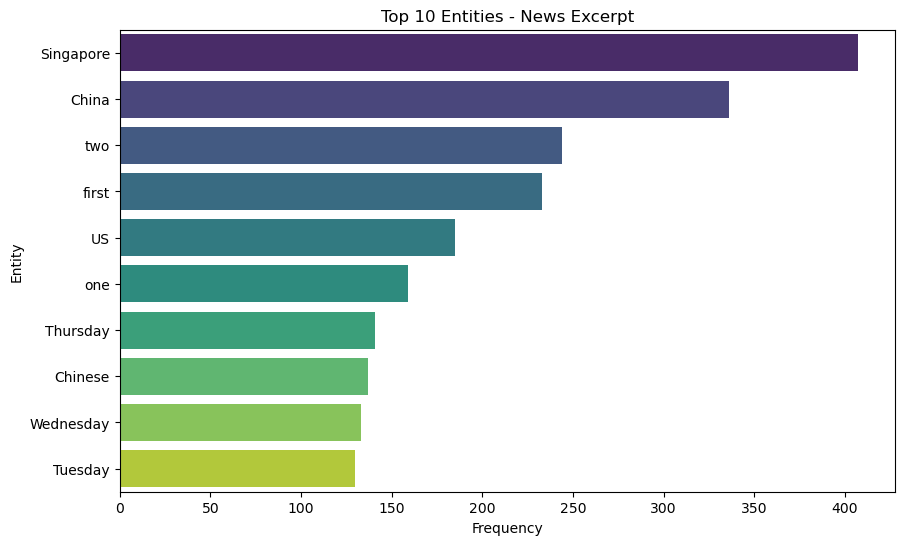

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


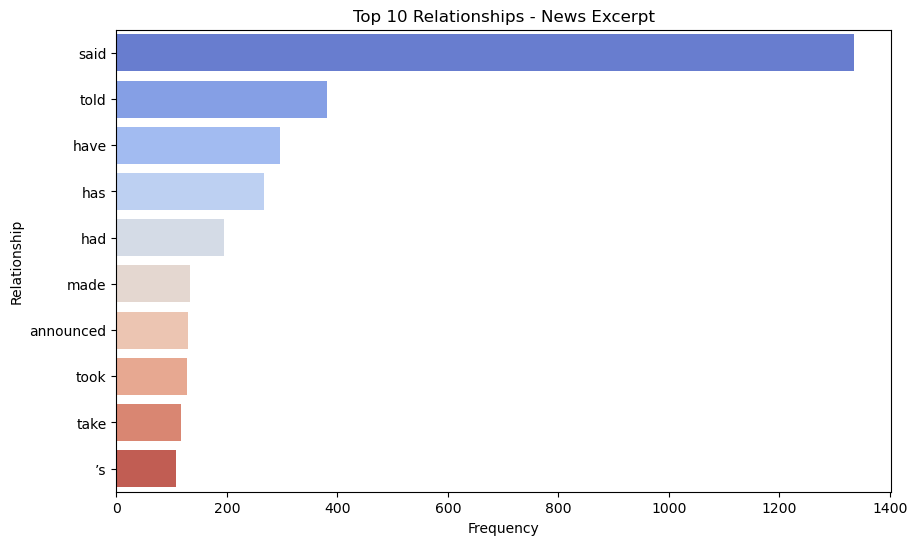

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


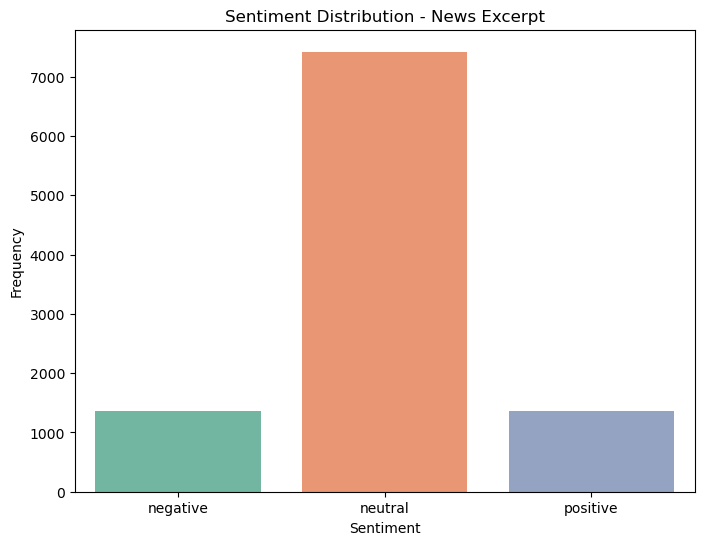

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


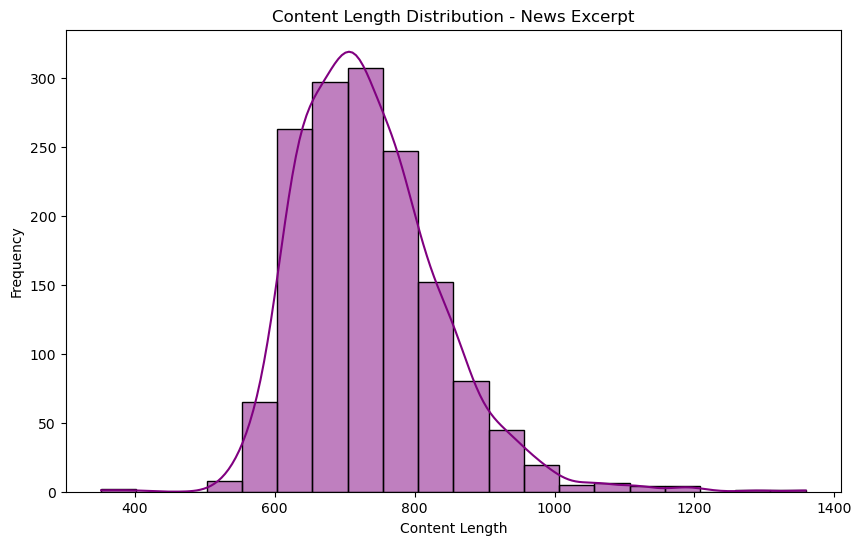

In [2]:
# Visualizations for entity_SA_newsexcerpt
print("Visualizations for entity_SA_newsexcerpt")
visualize_entities(df_newsexcerpt, "News Excerpt")
visualize_relationships(df_newsexcerpt, "News Excerpt")
visualize_sentiments(df_newsexcerpt, "News Excerpt")
visualize_content_length(df_newsexcerpt, "News Excerpt")



Visualizations for entity_SA_wikileaks


/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


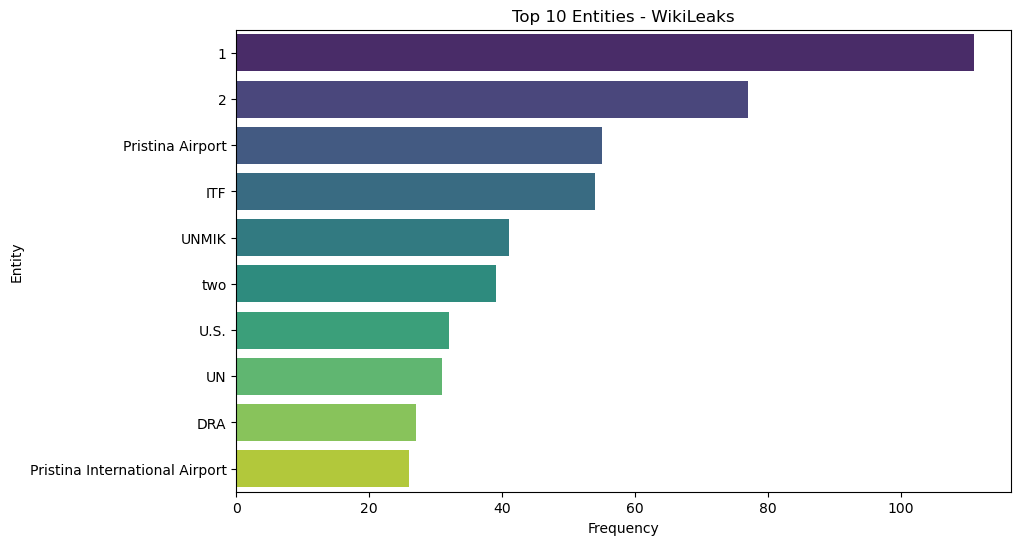

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


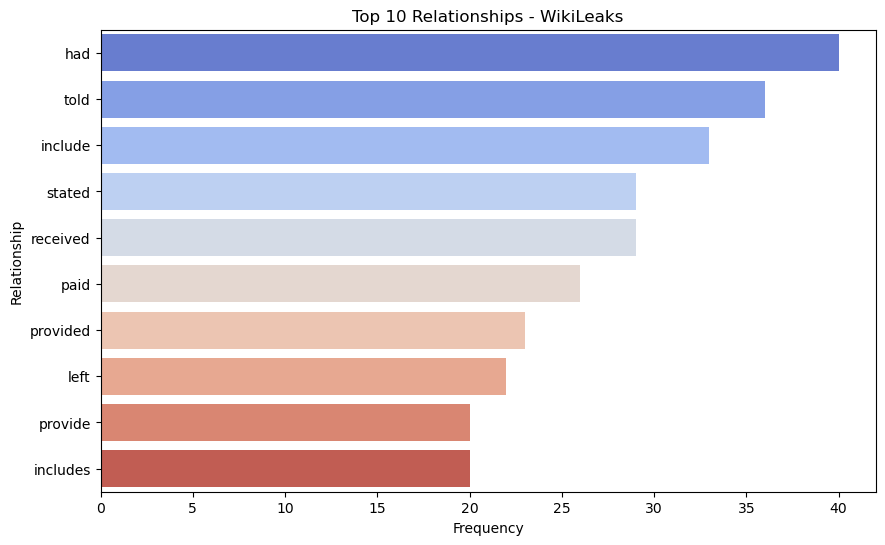

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


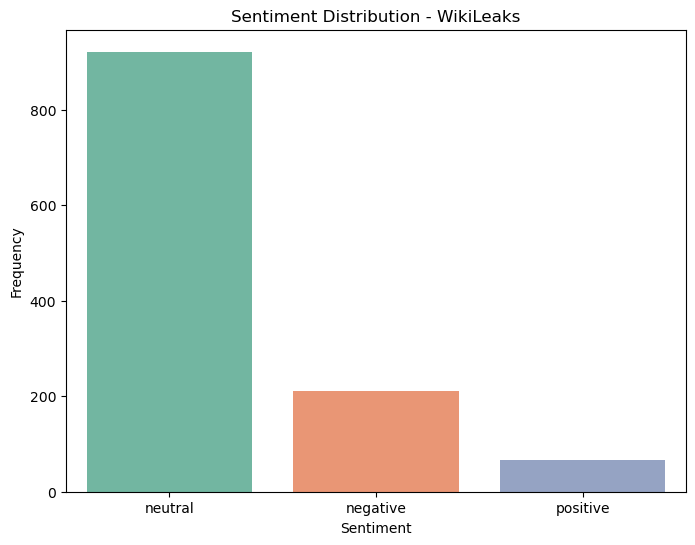

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


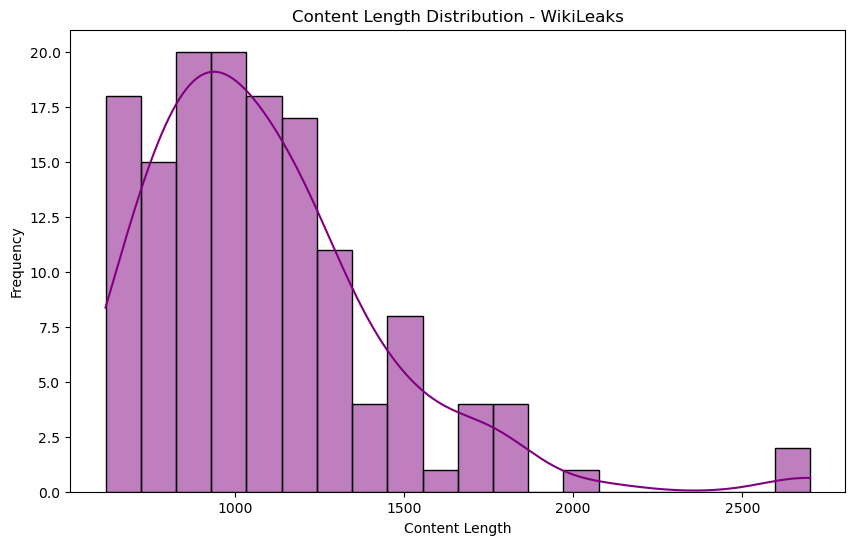

In [3]:
# Visualizations for entity_SA_wikileaks
print("Visualizations for entity_SA_wikileaks")
visualize_entities(df_wikileaks, "WikiLeaks")
visualize_relationships(df_wikileaks, "WikiLeaks")
visualize_sentiments(df_wikileaks, "WikiLeaks")
visualize_content_length(df_wikileaks, "WikiLeaks")


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

# Load the datasets
news_file = "./data/entity_SA_newsexcerpt.xlsx"
wikileaks_file = "./data/entity_SA_wikileaks.xlsx"

df_news = pd.read_excel(news_file)
df_wikileaks = pd.read_excel(wikileaks_file)

# Function to visualize entity frequency
def visualize_entity_frequency(df, title):
    entity_list = []
    for entities in df['entities']:
        if isinstance(entities, str):
            entity_list.extend(eval(entities))

    entity_names = [entity[0] for entity in entity_list]
    entity_counts = pd.Series(entity_names).value_counts().head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=entity_counts.values, y=entity_counts.index, palette="viridis")
    plt.title(f"Top 10 Entities in {title}")
    plt.xlabel("Count")
    plt.ylabel("Entity")
    plt.show()

# Function to visualize relationship frequency
def visualize_relationship_frequency(df, title):
    relationship_list = []
    for relationships in df['relationships']:
        if isinstance(relationships, str):
            relationship_list.extend(eval(relationships))

    relationship_names = [rel[1] for rel in relationship_list]
    relationship_counts = pd.Series(relationship_names).value_counts().head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=relationship_counts.values, y=relationship_counts.index, palette="magma")
    plt.title(f"Top 10 Relationships in {title}")
    plt.xlabel("Count")
    plt.ylabel("Relationship")
    plt.show()

# Function to visualize sentiment distribution
def visualize_sentiment_distribution(df, title):
    sentiments = []
    for entity_sentiments in df['entity_sentiments']:
        if isinstance(entity_sentiments, str):
            sentiments.extend([entry['sentiment'] for entry in eval(entity_sentiments)])

    sentiment_counts = pd.Series(sentiments).value_counts()

    plt.figure(figsize=(8, 5))
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="cool")
    plt.title(f"Sentiment Distribution in {title}")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()

# Function to visualize content length distribution
def visualize_content_length(df, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['content_length'], kde=True, color="blue", bins=20)
    plt.title(f"Content Length Distribution in {title}")
    plt.xlabel("Content Length")
    plt.ylabel("Frequency")
    plt.show()

# Function to visualize similarity among rows
def visualize_similarity(df, text_column, title):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df[text_column].fillna(""))
    similarity_matrix = cosine_similarity(tfidf_matrix)

    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, cmap="coolwarm", square=True)
    plt.title(f"Row Similarity Heatmap in {title}")
    plt.xlabel("Row Index")
    plt.ylabel("Row Index")
    plt.show()

# Function to visualize combined data insights
def visualize_combined(df1, df2):
    combined_df = pd.concat([df1, df2], ignore_index=True)

    # Combined entity frequency
    visualize_entity_frequency(combined_df, "Combined Dataset")

    # Combined sentiment distribution
    visualize_sentiment_distribution(combined_df, "Combined Dataset")

    # Combined content length distribution
    visualize_content_length(combined_df, "Combined Dataset")

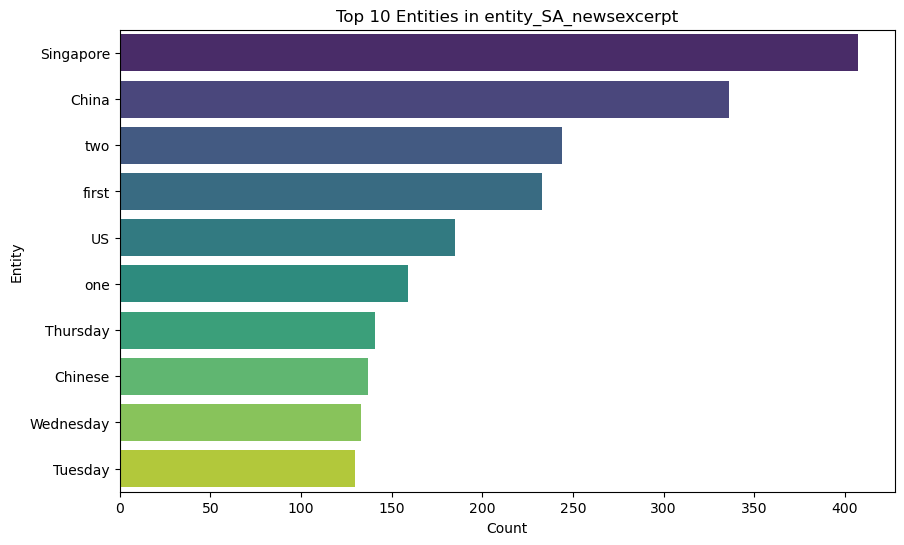

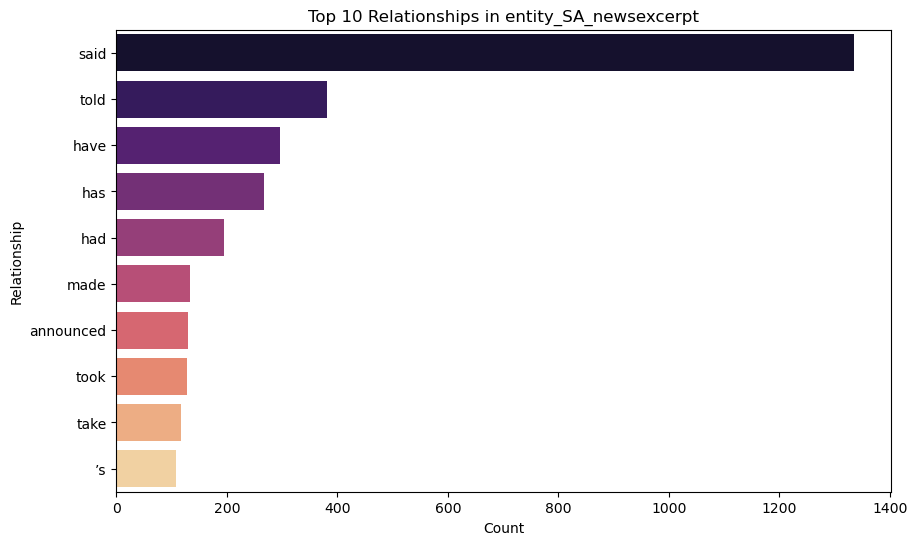

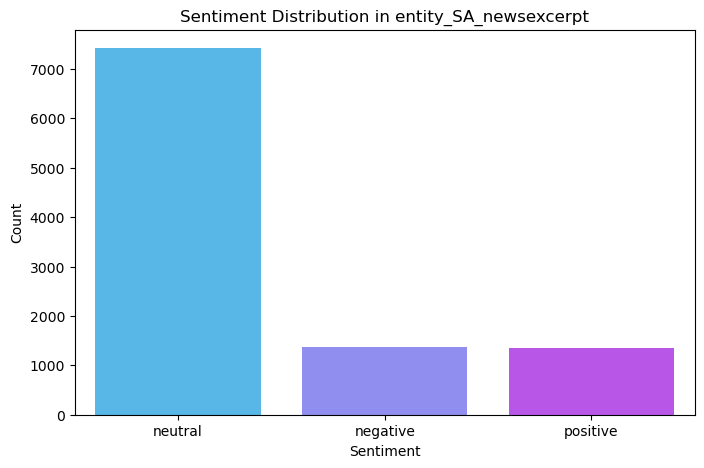

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


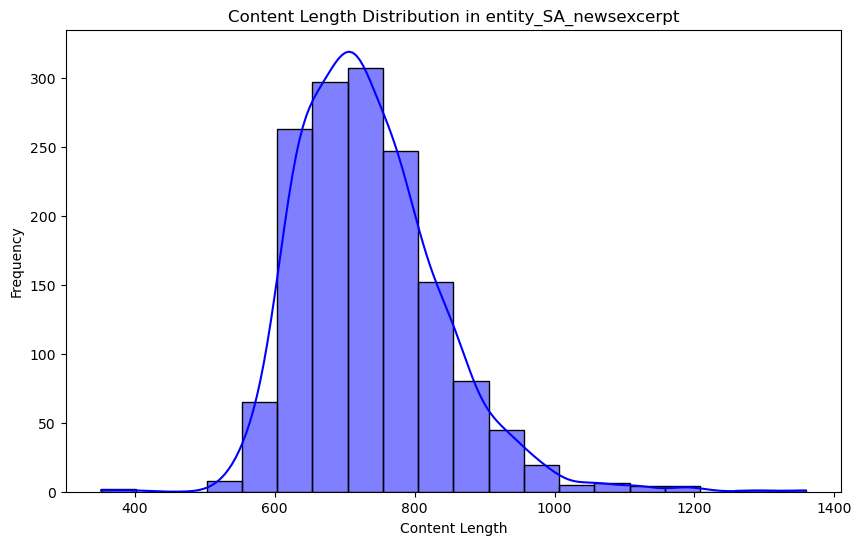

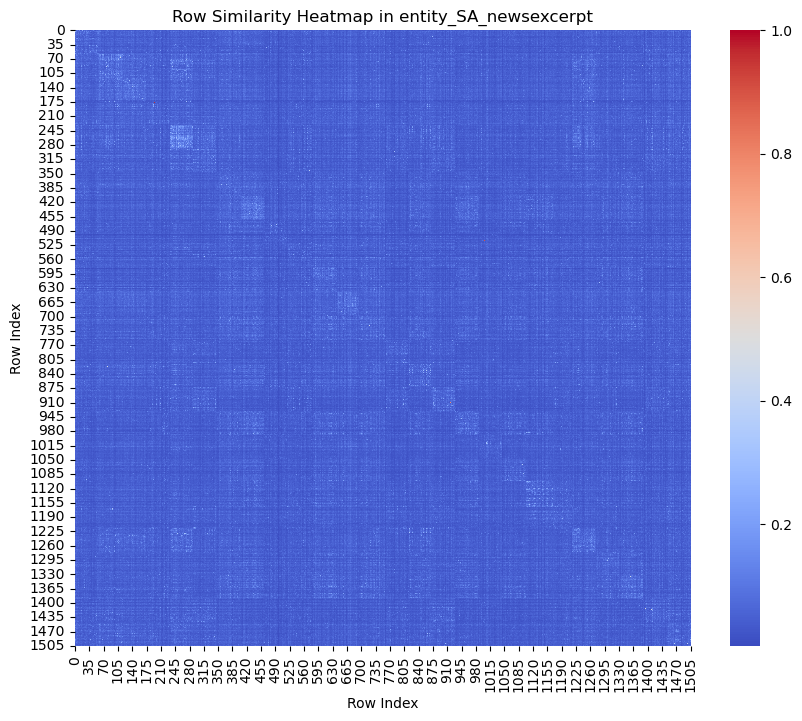

In [6]:
# Visualizations for entity_SA_newsexcerpt
df_news['text'] = df_news['Text']  # Ensure text column consistency
visualize_entity_frequency(df_news, "entity_SA_newsexcerpt")
visualize_relationship_frequency(df_news, "entity_SA_newsexcerpt")
visualize_sentiment_distribution(df_news, "entity_SA_newsexcerpt")
visualize_content_length(df_news, "entity_SA_newsexcerpt")
visualize_similarity(df_news, "text", "entity_SA_newsexcerpt")

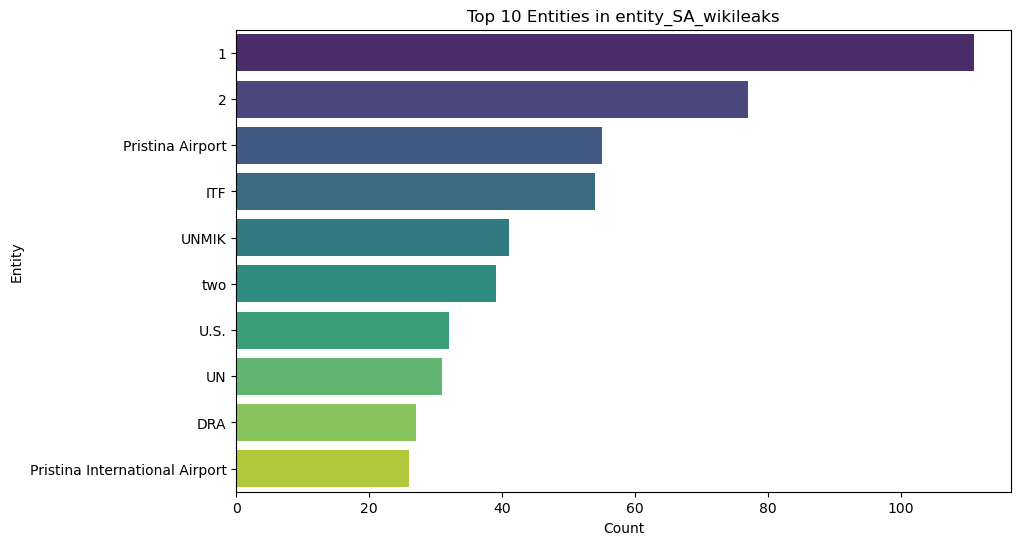

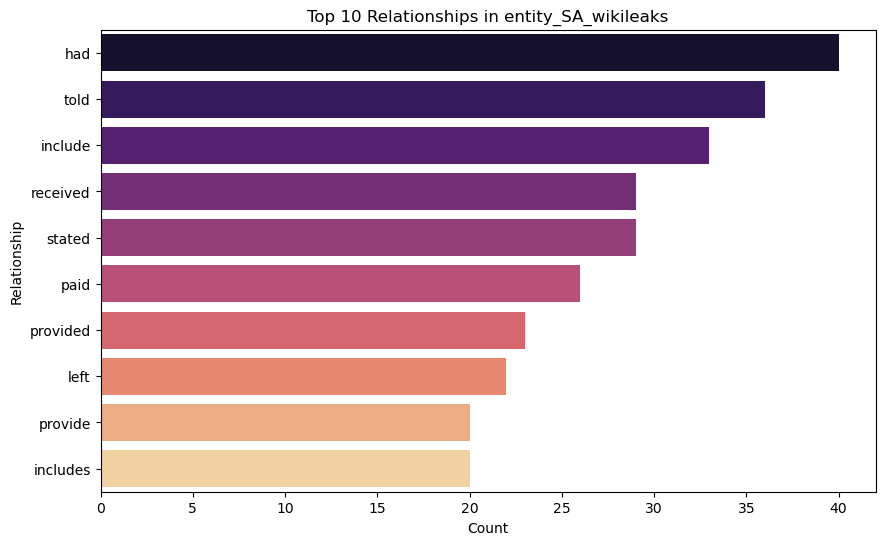

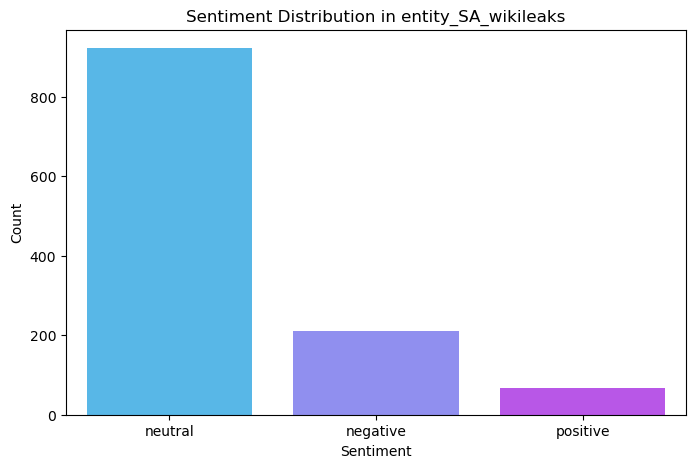

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


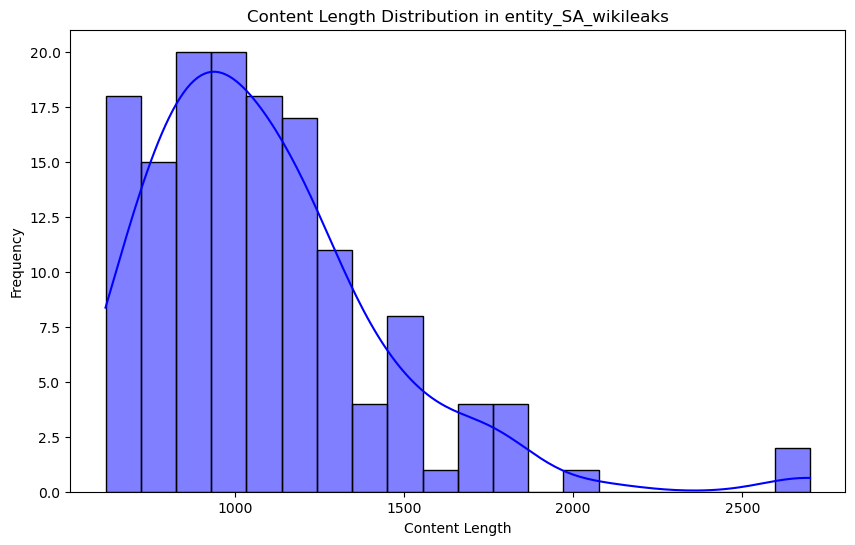

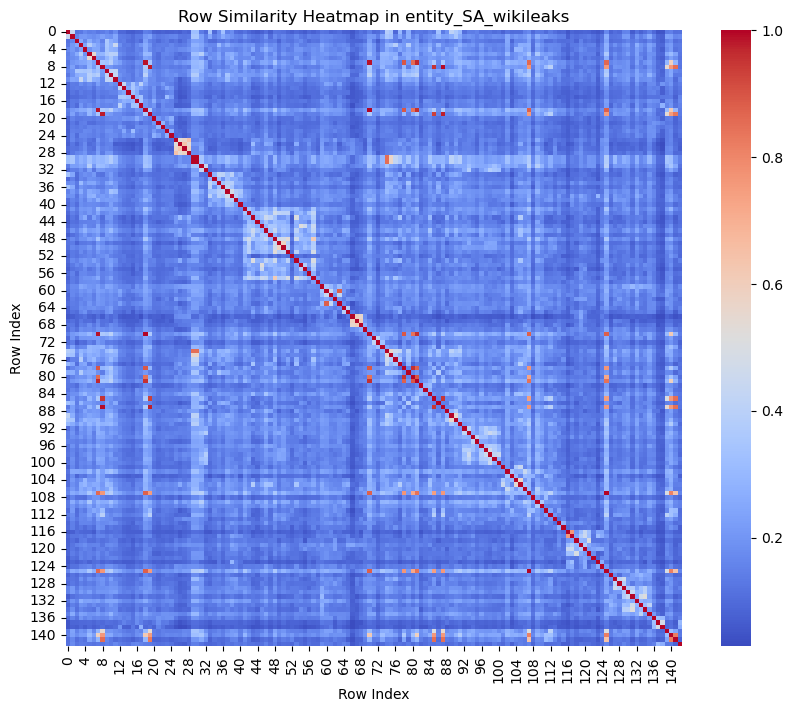

In [7]:
# Visualizations for entity_SA_wikileaks
df_wikileaks['text'] = df_wikileaks['Text']  # Ensure text column consistency
visualize_entity_frequency(df_wikileaks, "entity_SA_wikileaks")
visualize_relationship_frequency(df_wikileaks, "entity_SA_wikileaks")
visualize_sentiment_distribution(df_wikileaks, "entity_SA_wikileaks")
visualize_content_length(df_wikileaks, "entity_SA_wikileaks")
visualize_similarity(df_wikileaks, "text", "entity_SA_wikileaks")


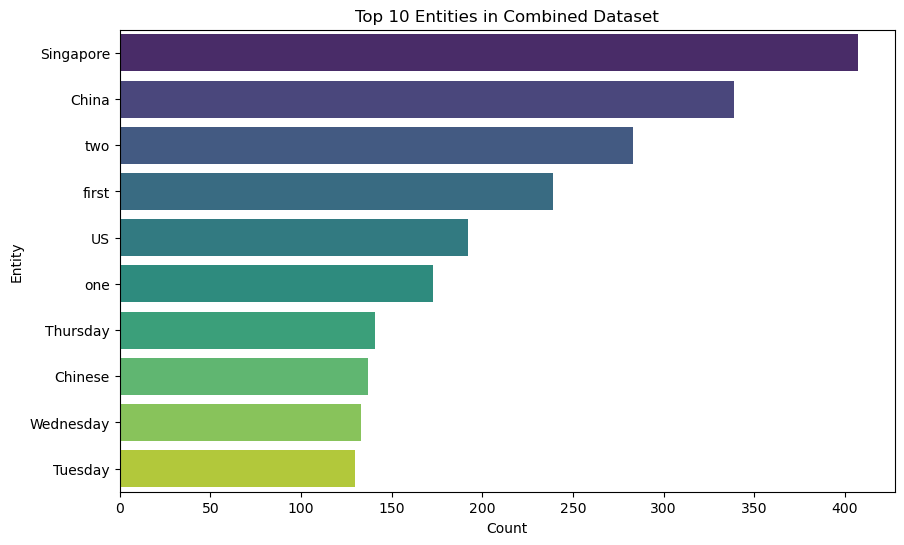

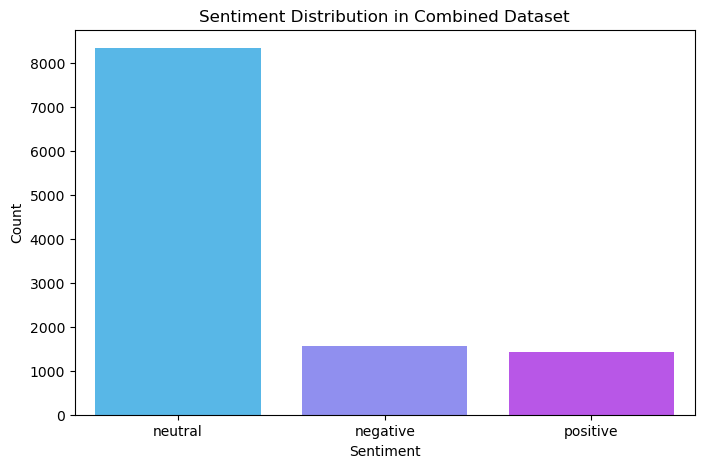

/Users/rishi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


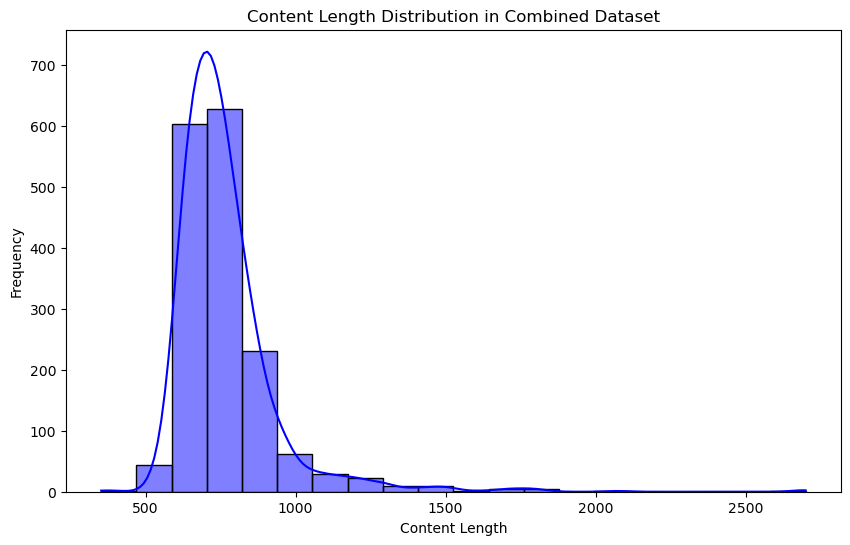

In [8]:
# Combined visualizations
visualize_combined(df_news, df_wikileaks)


# Visualization of sentence BERT

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from wordcloud import WordCloud

# Load the dataset
file_path = "./data/sentencebert_results.xlsx"  # Replace with your file path
df = pd.read_excel(file_path)

# Set a larger figure size for better visualizations
plt.rcParams['figure.figsize'] = [12, 8]

# 1. Distribution of Content Similarity
plt.figure()
sns.histplot(df['content_similarity'], kde=True, bins=20, color='blue')
plt.title('Distribution of Content Similarity')
plt.xlabel('Content Similarity')
plt.ylabel('Frequency')
plt.show()

# 2. Count of News Categories and WikiLeaks Categories
plt.figure()
sns.countplot(y=df['news_Category_x'], order=df['news_Category_x'].value_counts().index, palette="viridis")
plt.title('News Categories Distribution')
plt.xlabel('Count')
plt.ylabel('News Category')
plt.show()

plt.figure()
sns.countplot(y=df['wikileaks_Category'], order=df['wikileaks_Category'].value_counts().index, palette="viridis")
plt.title('WikiLeaks Categories Distribution')
plt.xlabel('Count')
plt.ylabel('WikiLeaks Category')
plt.show()

# 3. Scatterplot of Content Similarity vs News Categories
plt.figure()
sns.boxplot(x='news_Category_x', y='content_similarity', data=df, palette='coolwarm')
plt.title('Content Similarity by News Categories')
plt.xticks(rotation=45)
plt.xlabel('News Category')
plt.ylabel('Content Similarity')
plt.show()

# 4. Word Clouds for News and WikiLeaks Entities
news_entities = ' '.join(df['news_entities'].dropna().astype(str).values)
wikileaks_entities = ' '.join(df['wikileaks_entities'].dropna().astype(str).values)

news_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(news_entities)
wikileaks_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wikileaks_entities)

plt.figure()
plt.imshow(news_wordcloud, interpolation='bilinear')
plt.title('Word Cloud of News Entities')
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(wikileaks_wordcloud, interpolation='bilinear')
plt.title('Word Cloud of WikiLeaks Entities')
plt.axis('off')
plt.show()

# 5. Network Graph of Relationships (News and WikiLeaks)
G = nx.Graph()

# Adding edges for news relationships
for index, row in df.iterrows():
    if pd.notna(row['news_relationships']):
        relationships = eval(row['news_relationships'])  # Convert string to list of tuples
        for rel in relationships:
            G.add_edge(rel[0], rel[1], label=rel[2])

# Adding edges for wikileaks relationships
for index, row in df.iterrows():
    if pd.notna(row['wikileaks_relationships']):
        relationships = eval(row['wikileaks_relationships'])
        for rel in relationships:
            G.add_edge(rel[0], rel[1], label=rel[2])

plt.figure()
pos = nx.spring_layout(G, k=0.3)  # Layout for better visualization
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', edge_color='gray', font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['label'] for u, v, d in G.edges(data=True)}, font_size=8)
plt.title('Network Graph of Entities and Relationships')
plt.show()

# 6. Heatmap of Content Similarity for Top News and WikiLeaks Categories
category_similarity = df.groupby(['news_Category_x', 'wikileaks_Category'])['content_similarity'].mean().unstack()

plt.figure()
sns.heatmap(category_similarity, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Heatmap of Content Similarity Across Categories')
plt.xlabel('WikiLeaks Categories')
plt.ylabel('News Categories')
plt.show()

# 7. Pairplot for Numerical Insights (if other numerical columns are present)
if df.select_dtypes(include=['float64', 'int64']).shape[1] > 1:
    sns.pairplot(df.select_dtypes(include=['float64', 'int64']))
    plt.show()


ModuleNotFoundError: No module named 'wordcloud'